In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1023.33it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1023.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 965.76it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=dataset_train_cost.costs)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.01it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-5, num_epochs+5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 20), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 100
log_step = 10

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e0):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with NNLS

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

(CVXPY) Dec 05 07:03:01 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    9, Loss:  -0.8480:  10%|█████▎                                               | 10/100 [00:18<02:08,  1.43s/it]

Epoch  10, Train Regret:   8.7697%, Val Regret:  10.2425%


Epoch   19, Loss:  -0.9216:  20%|██████████▌                                          | 20/100 [00:33<01:52,  1.41s/it]

Epoch  20, Train Regret:   9.7115%, Val Regret:  10.2253%


Epoch   29, Loss:  -0.7699:  30%|███████████████▉                                     | 30/100 [00:49<01:39,  1.41s/it]

Epoch  30, Train Regret:   9.2405%, Val Regret:  10.4296%


Epoch   39, Loss:  -0.9037:  40%|█████████████████████▏                               | 40/100 [01:05<01:24,  1.41s/it]

Epoch  40, Train Regret:   8.9124%, Val Regret:   9.4615%


Epoch   49, Loss:  -0.9217:  50%|██████████████████████████▌                          | 50/100 [01:20<01:10,  1.42s/it]

Epoch  50, Train Regret:   9.0048%, Val Regret:   8.5953%


Epoch   59, Loss:  -0.9109:  60%|███████████████████████████████▊                     | 60/100 [01:36<00:56,  1.42s/it]

Epoch  60, Train Regret:   8.0959%, Val Regret:   8.8198%


Epoch   69, Loss:  -0.7447:  70%|█████████████████████████████████████                | 70/100 [01:52<00:43,  1.46s/it]

Epoch  70, Train Regret:   8.4115%, Val Regret:  10.5878%


Epoch   79, Loss:  -0.9096:  80%|██████████████████████████████████████████▍          | 80/100 [02:08<00:32,  1.60s/it]


Epoch  80, Train Regret:   8.8190%, Val Regret:  10.1762%

Early Stop!
Training Elapsed Time: 32.56 Sec

Evaluation:
Test Regret: 9.1331%
Test Elapsed Time: 1.54 Sec


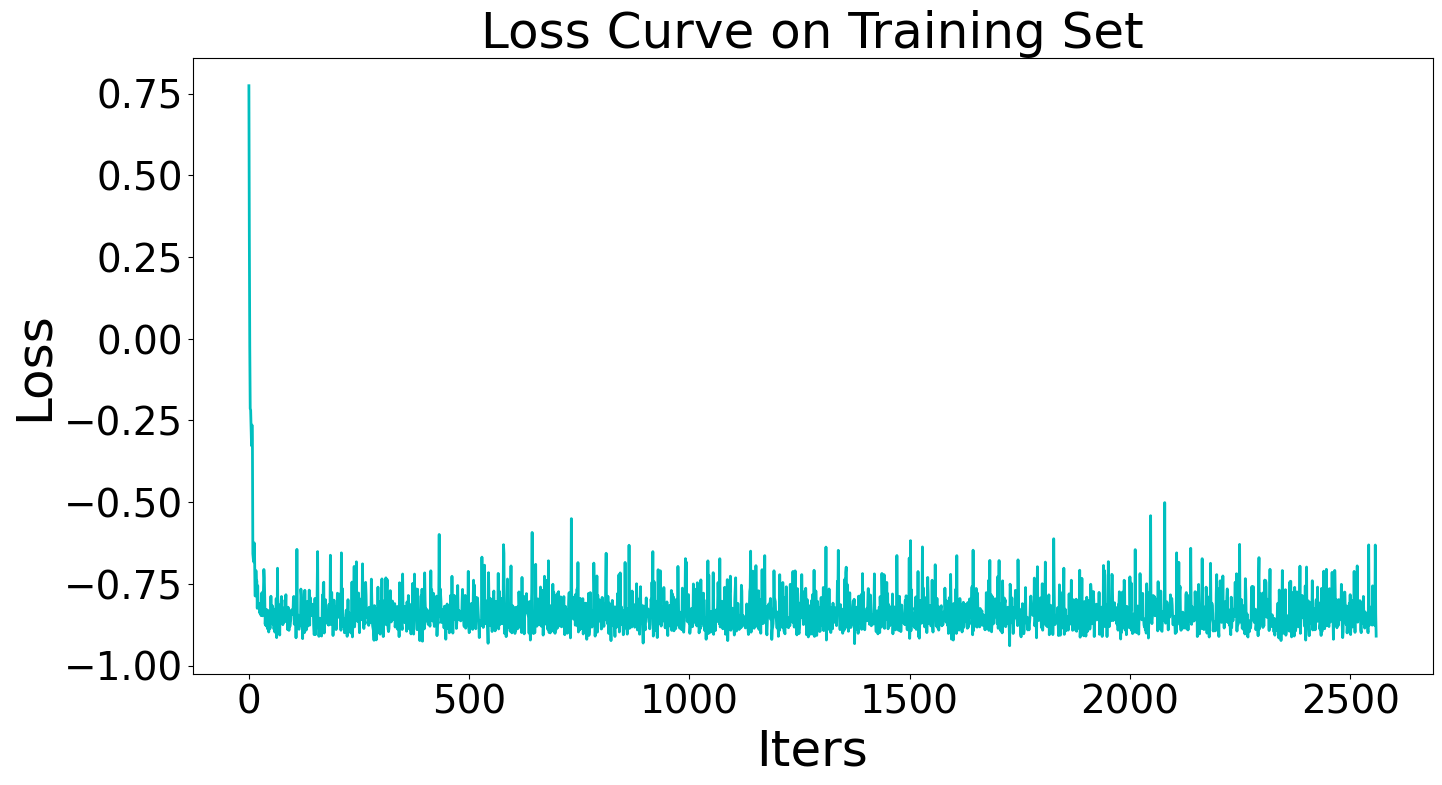

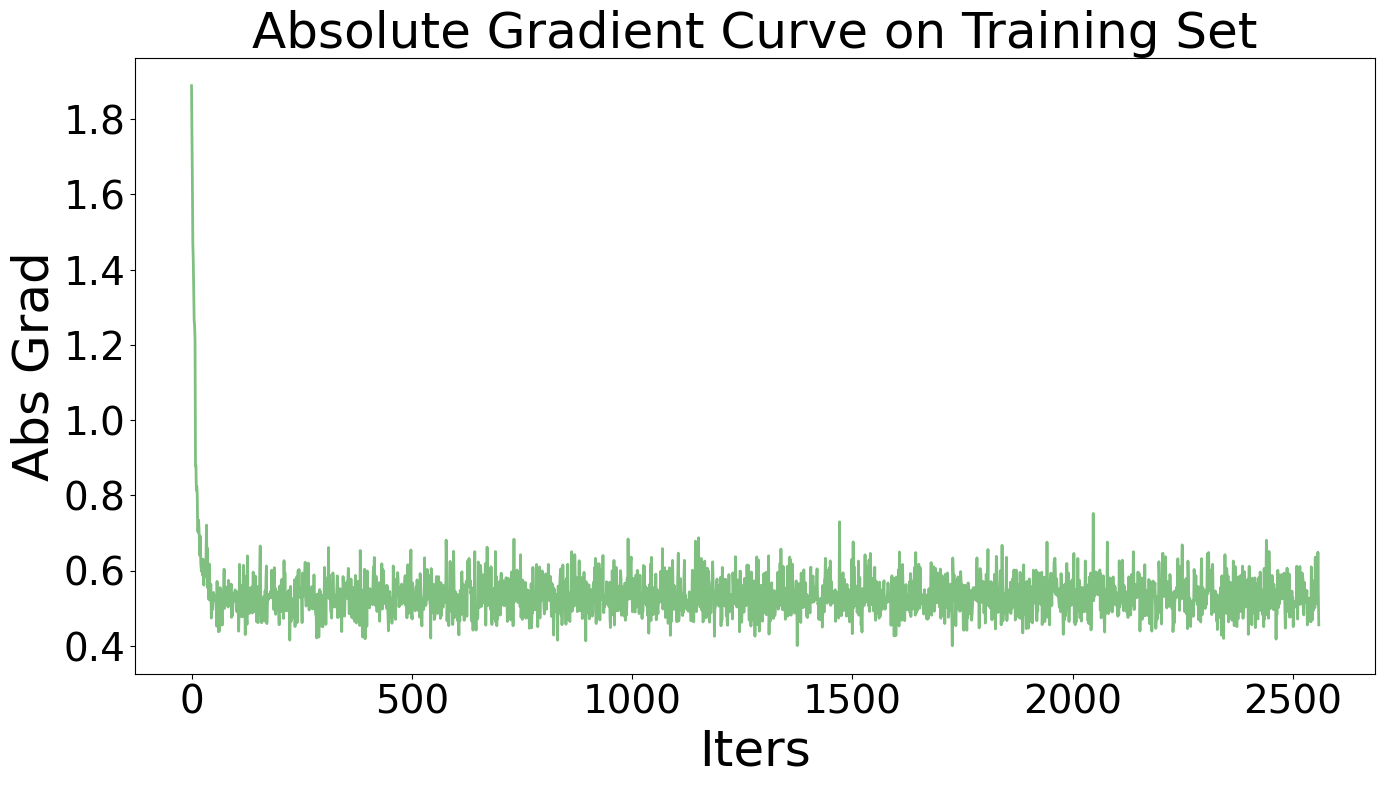

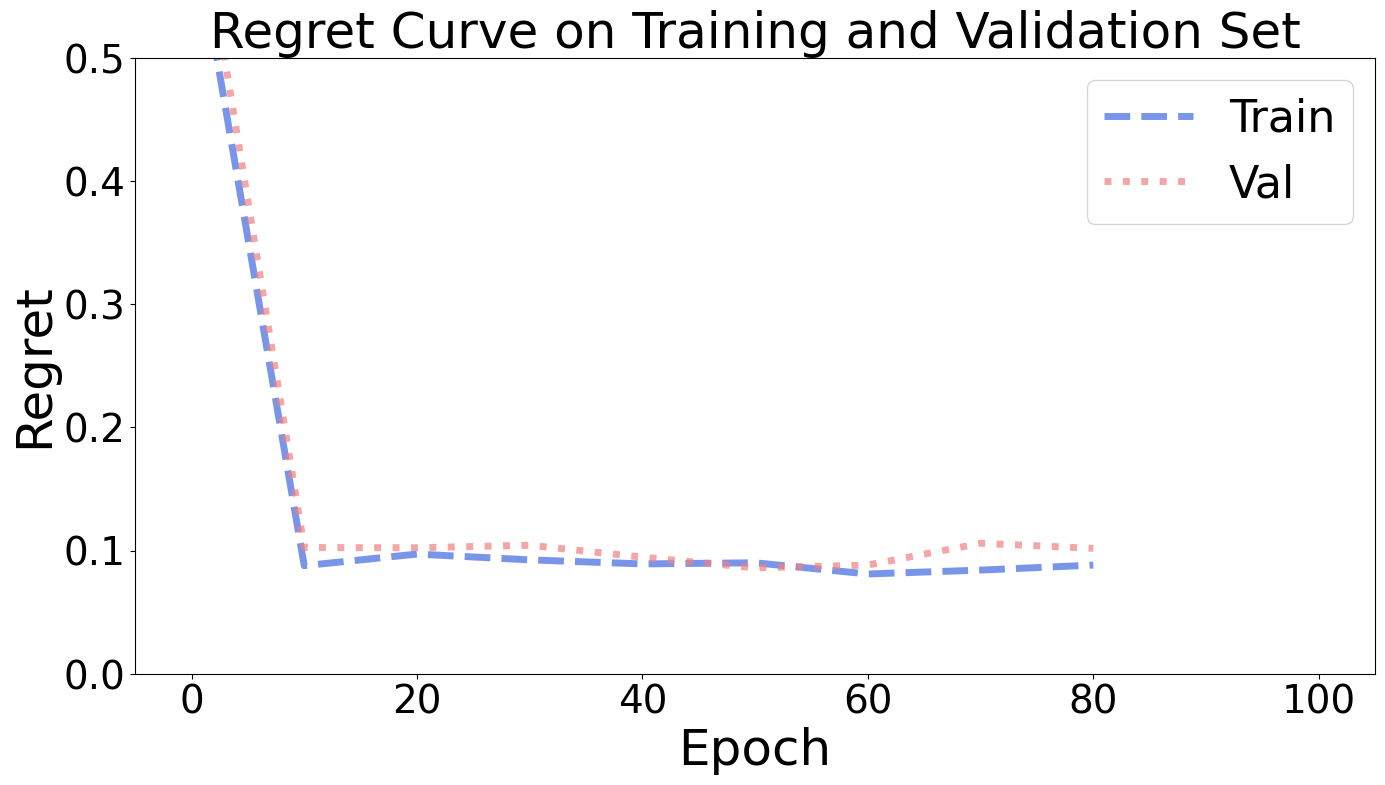

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with NNLS 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [18]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  54.7757%, Val Regret:  60.3469%


Epoch    9, Loss:  -0.8612:  10%|█████▎                                               | 10/100 [00:17<02:08,  1.43s/it]

Epoch  10, Train Regret:   7.7302%, Val Regret:   8.0060%


Epoch   19, Loss:  -0.9282:  20%|██████████▌                                          | 20/100 [00:33<01:54,  1.43s/it]

Epoch  20, Train Regret:   7.6531%, Val Regret:   8.0794%


Epoch   29, Loss:  -0.7772:  30%|███████████████▉                                     | 30/100 [00:49<01:40,  1.43s/it]

Epoch  30, Train Regret:   7.5213%, Val Regret:   8.2767%


Epoch   39, Loss:  -0.9068:  40%|█████████████████████▏                               | 40/100 [01:05<01:27,  1.46s/it]

Epoch  40, Train Regret:   7.7782%, Val Regret:   7.4977%


Epoch   49, Loss:  -0.9267:  50%|██████████████████████████▌                          | 50/100 [01:21<01:12,  1.44s/it]

Epoch  50, Train Regret:   7.7048%, Val Regret:   8.1058%


Epoch   59, Loss:  -0.9243:  60%|███████████████████████████████▊                     | 60/100 [01:37<00:58,  1.45s/it]

Epoch  60, Train Regret:   7.6293%, Val Regret:   8.4598%


Epoch   69, Loss:  -0.7697:  70%|█████████████████████████████████████                | 70/100 [01:53<00:48,  1.62s/it]


Epoch  70, Train Regret:   7.7088%, Val Regret:   9.0624%

Early Stop!
Training Elapsed Time: 29.01 Sec

Evaluation:
Test Regret: 8.3611%
Test Elapsed Time: 1.59 Sec


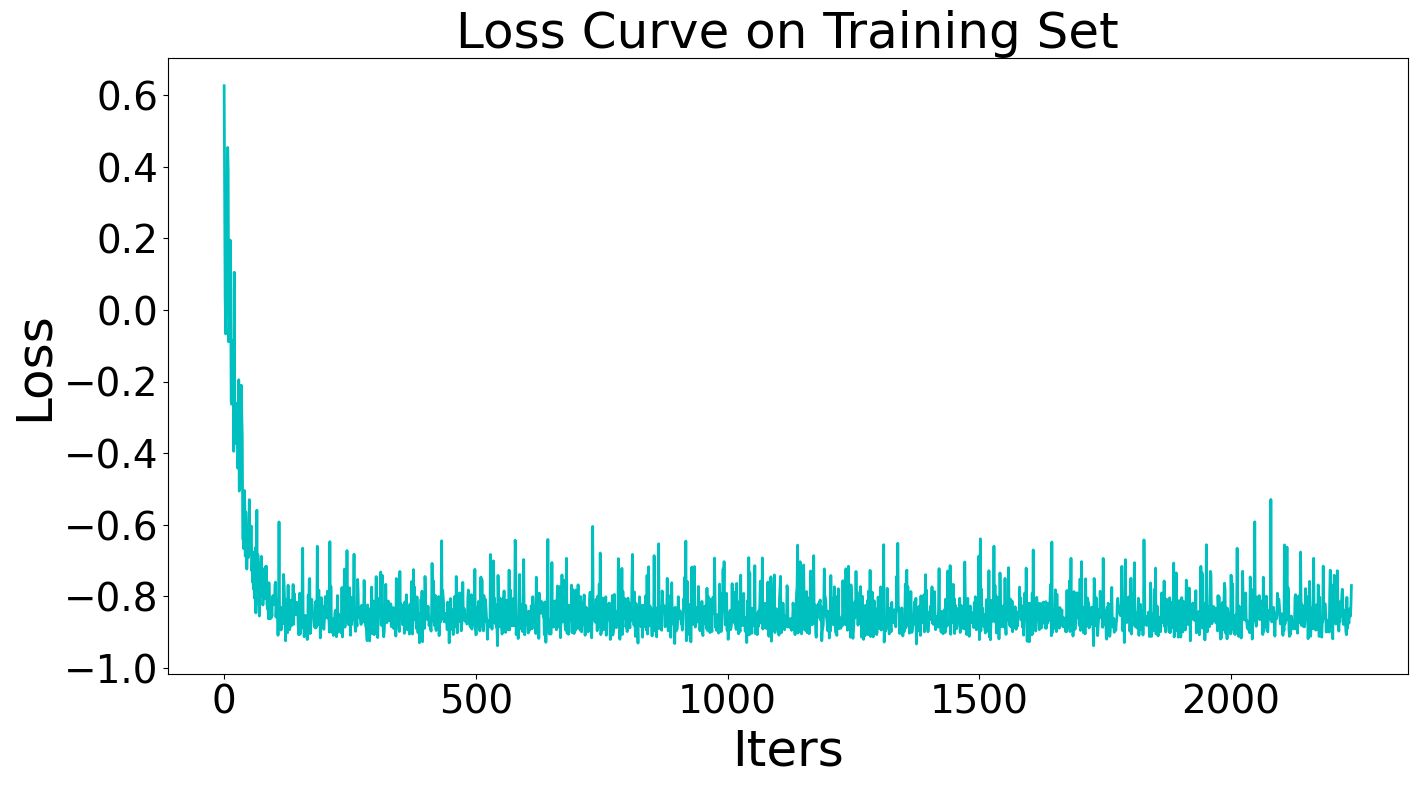

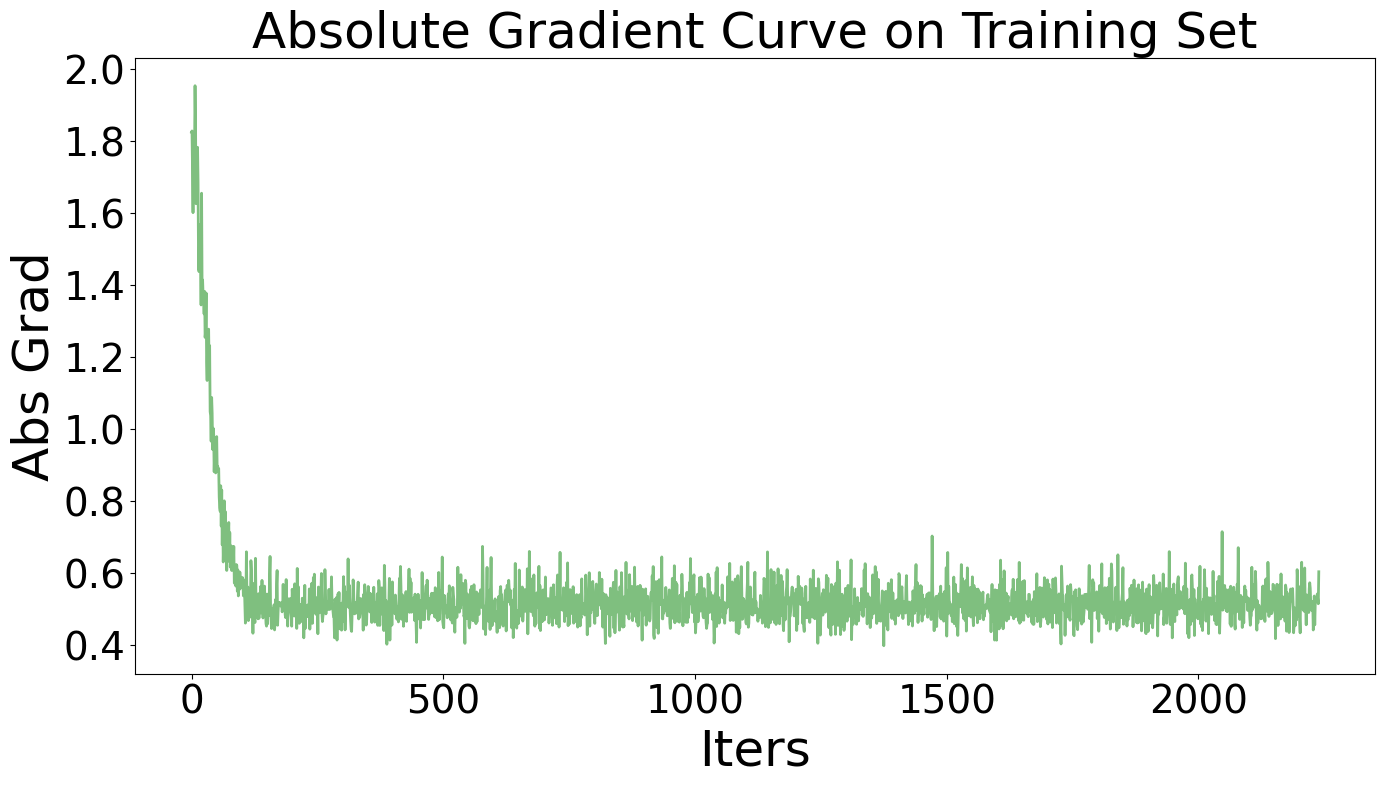

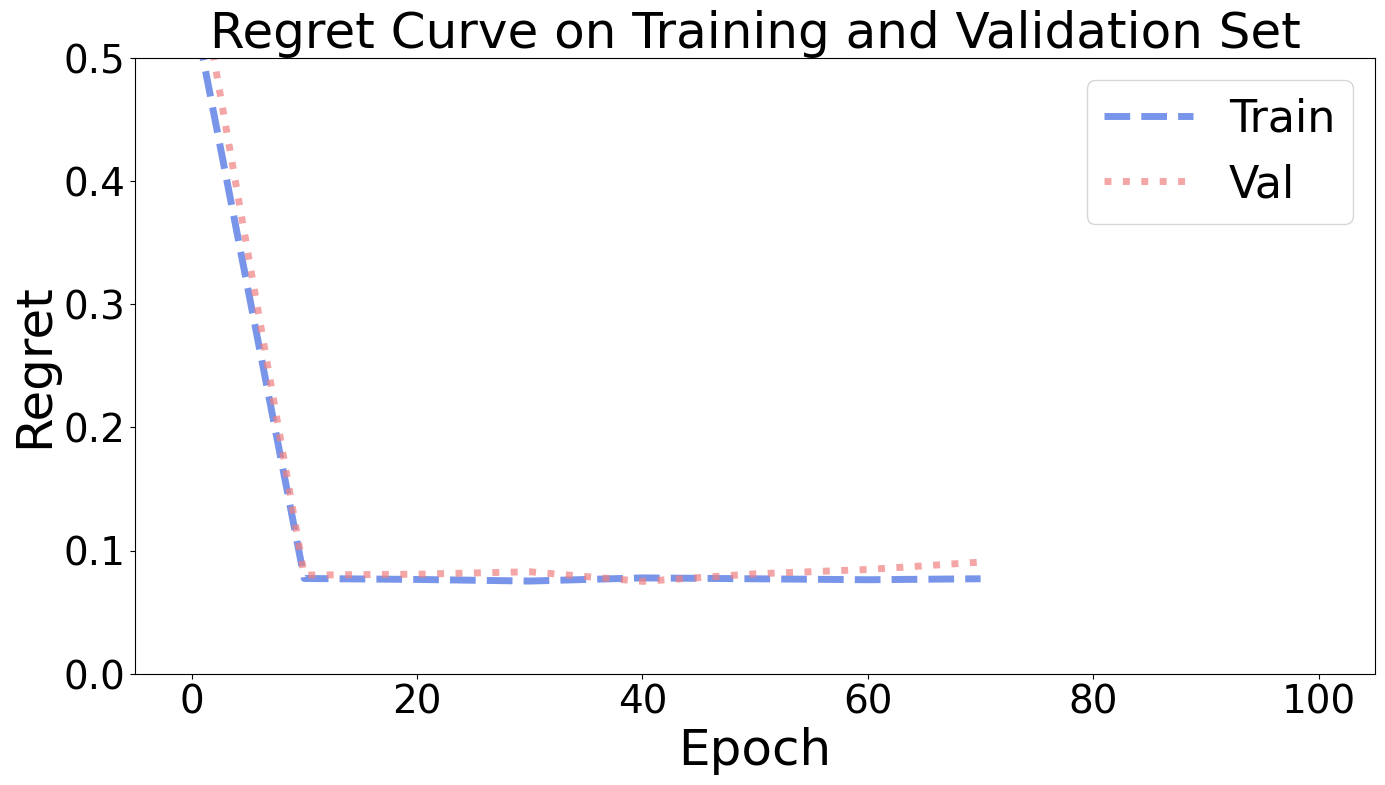

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", solve_ratio=0.1, processes=1)

Num of cores: 1


In [22]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  63.1727%, Val Regret:  60.3515%


Epoch    9, Loss:  -0.8621:  10%|█████▎                                               | 10/100 [00:14<01:47,  1.19s/it]

Epoch  10, Train Regret:   7.6937%, Val Regret:   8.0841%


Epoch   19, Loss:  -0.9288:  20%|██████████▌                                          | 20/100 [00:28<01:33,  1.17s/it]

Epoch  20, Train Regret:   7.7113%, Val Regret:   8.0419%


Epoch   29, Loss:  -0.7772:  30%|███████████████▉                                     | 30/100 [00:41<01:21,  1.17s/it]

Epoch  30, Train Regret:   7.6055%, Val Regret:   8.5263%


Epoch   39, Loss:  -0.9072:  40%|█████████████████████▏                               | 40/100 [00:54<01:09,  1.17s/it]

Epoch  40, Train Regret:   8.0354%, Val Regret:   7.8587%


Epoch   49, Loss:  -0.9273:  50%|██████████████████████████▌                          | 50/100 [01:07<00:58,  1.17s/it]

Epoch  50, Train Regret:   7.7170%, Val Regret:   8.0496%


Epoch   59, Loss:  -0.9246:  60%|███████████████████████████████▊                     | 60/100 [01:20<00:46,  1.17s/it]

Epoch  60, Train Regret:   7.5949%, Val Regret:   8.6096%


Epoch   69, Loss:  -0.7700:  70%|█████████████████████████████████████                | 70/100 [01:34<00:40,  1.35s/it]


Epoch  70, Train Regret:   7.8096%, Val Regret:   8.2827%

Early Stop!
Training Elapsed Time: 10.00 Sec

Evaluation:
Test Regret: 8.6281%
Test Elapsed Time: 1.78 Sec


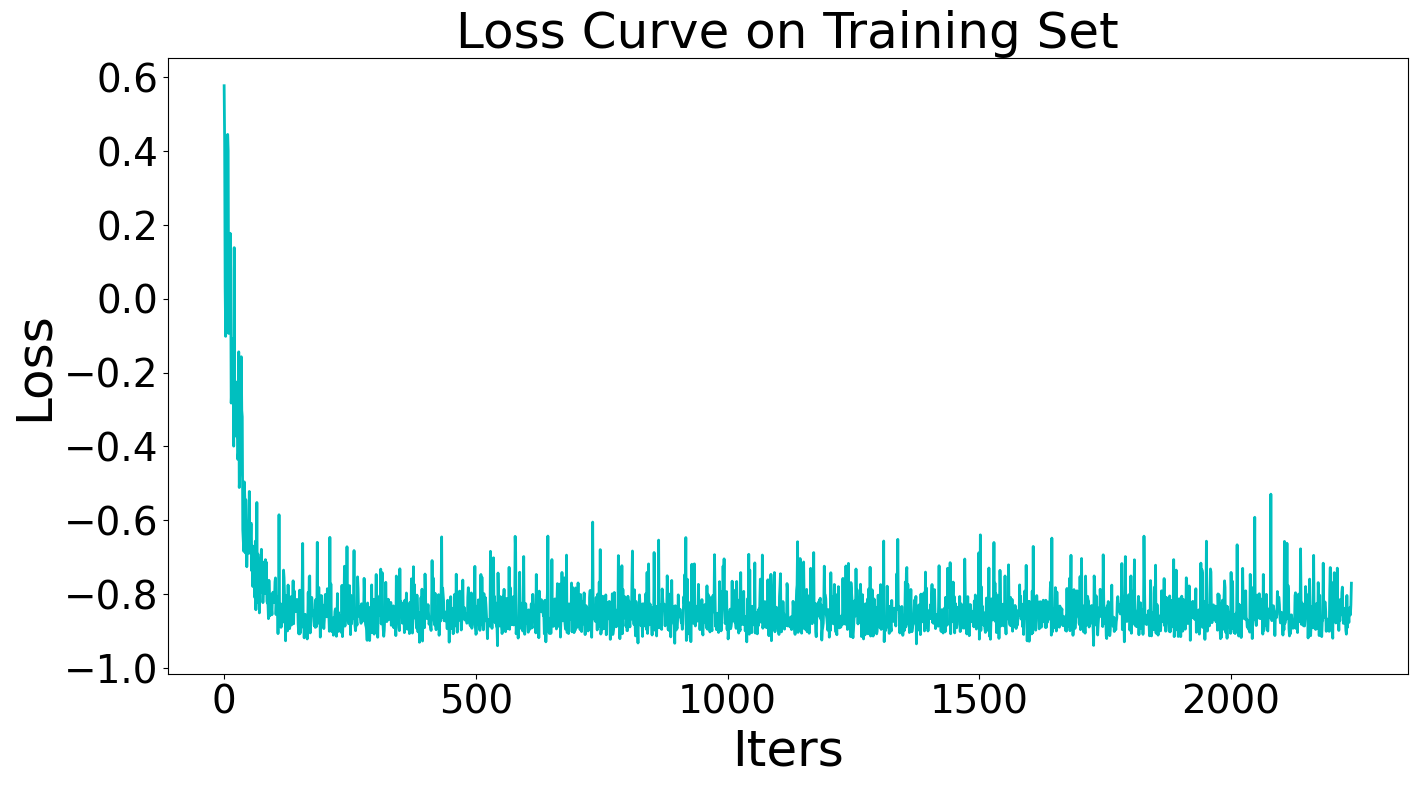

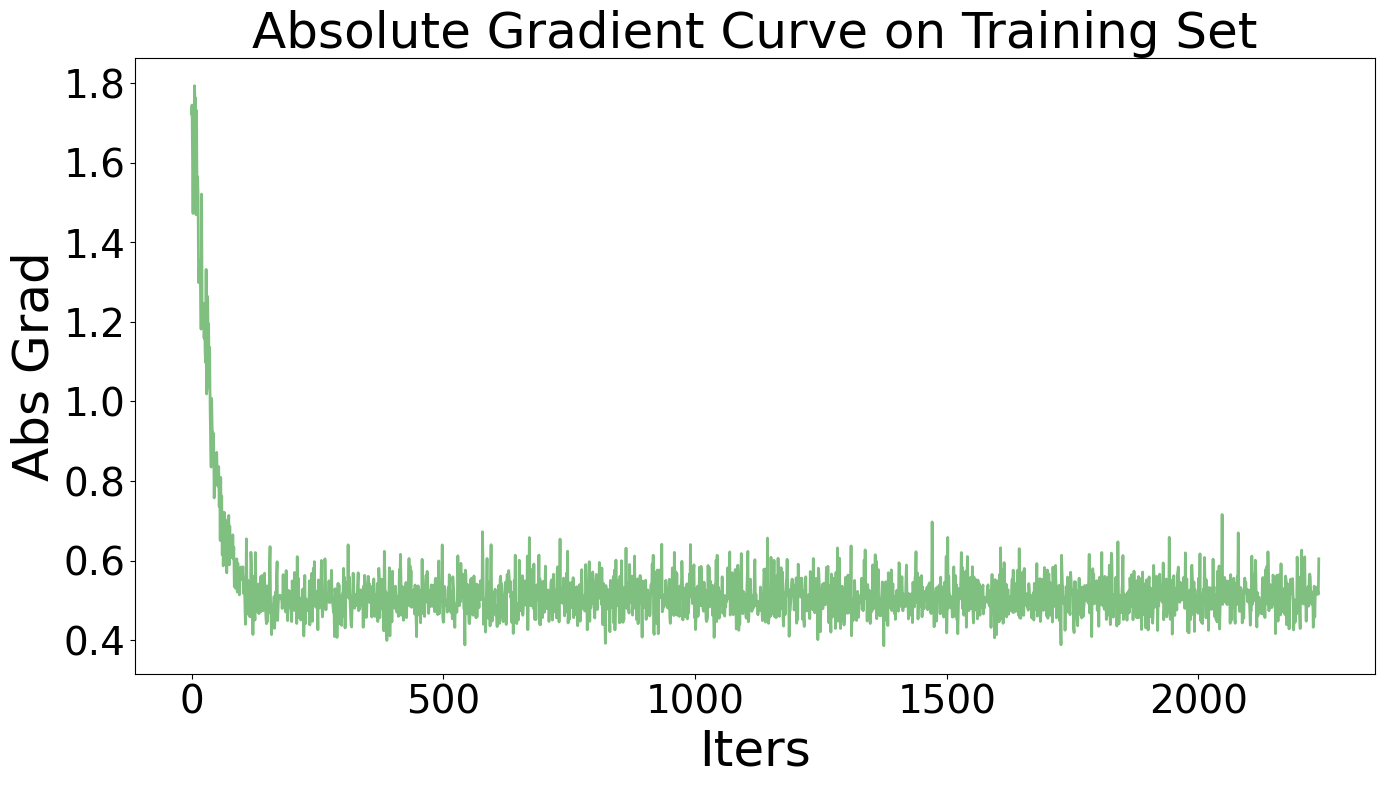

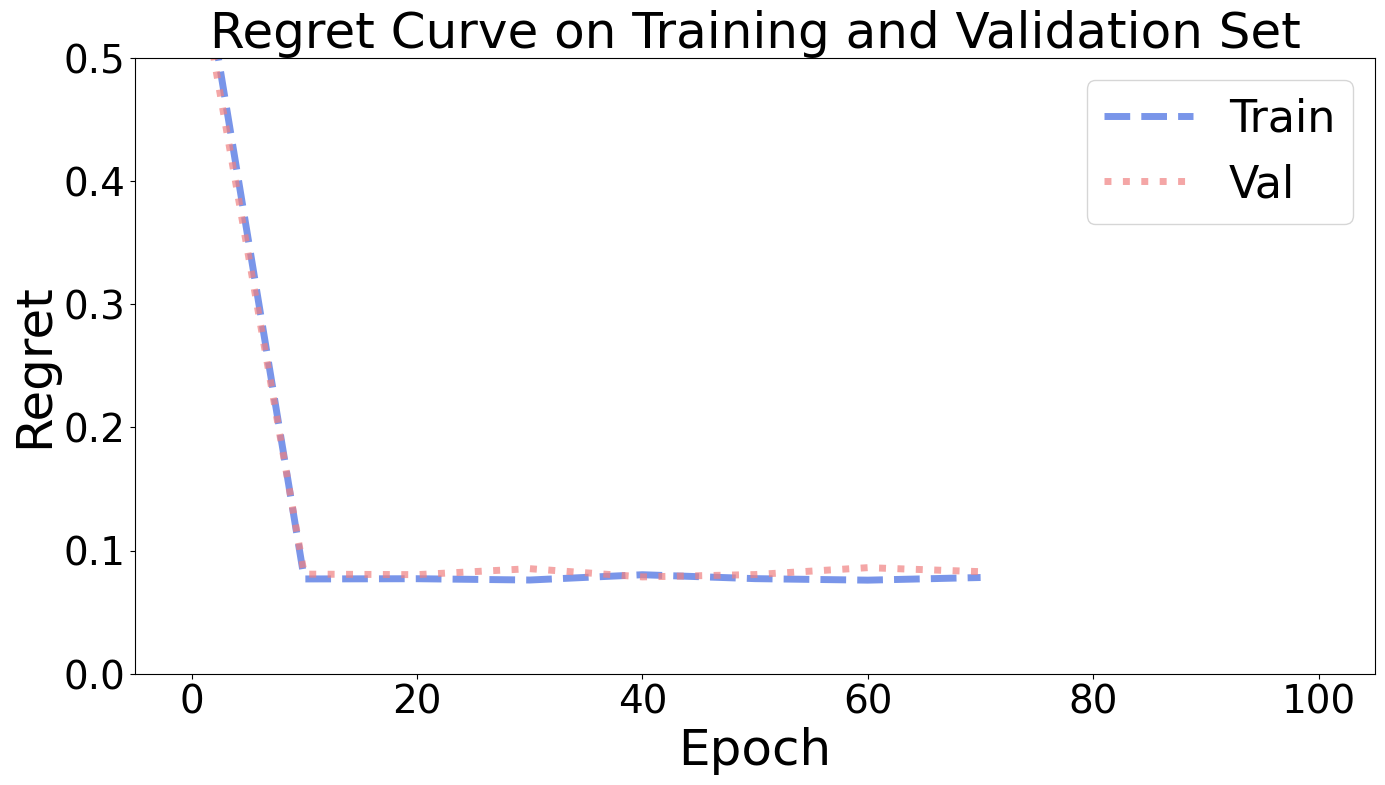

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  63.1727%, Val Regret:  60.3515%


Epoch    9, Loss:  -0.9469:  10%|█████▎                                               | 10/100 [00:16<01:58,  1.31s/it]

Epoch  10, Train Regret:   7.7321%, Val Regret:   8.6346%


Epoch   19, Loss:  -0.8162:  20%|██████████▌                                          | 20/100 [00:31<01:42,  1.28s/it]

Epoch  20, Train Regret:   7.7876%, Val Regret:   8.3074%


Epoch   29, Loss:  -0.8518:  30%|███████████████▉                                     | 30/100 [00:45<01:29,  1.27s/it]

Epoch  30, Train Regret:   7.8693%, Val Regret:   8.7649%


Epoch   39, Loss:  -0.9315:  40%|█████████████████████▏                               | 40/100 [00:59<01:18,  1.31s/it]

Epoch  40, Train Regret:   7.8197%, Val Regret:   7.5271%


Epoch   49, Loss:  -0.4851:  50%|██████████████████████████▌                          | 50/100 [01:13<01:02,  1.25s/it]

Epoch  50, Train Regret:   7.6669%, Val Regret:   7.6816%


Epoch   59, Loss:  -0.9395:  60%|███████████████████████████████▊                     | 60/100 [01:27<00:50,  1.25s/it]

Epoch  60, Train Regret:   7.7237%, Val Regret:   8.7142%


Epoch   69, Loss:  -0.7798:  70%|█████████████████████████████████████                | 70/100 [01:41<00:43,  1.45s/it]


Epoch  70, Train Regret:   7.6747%, Val Regret:   7.8137%

Early Stop!
Training Elapsed Time: 16.75 Sec

Evaluation:
Test Regret: 8.3703%
Test Elapsed Time: 1.53 Sec


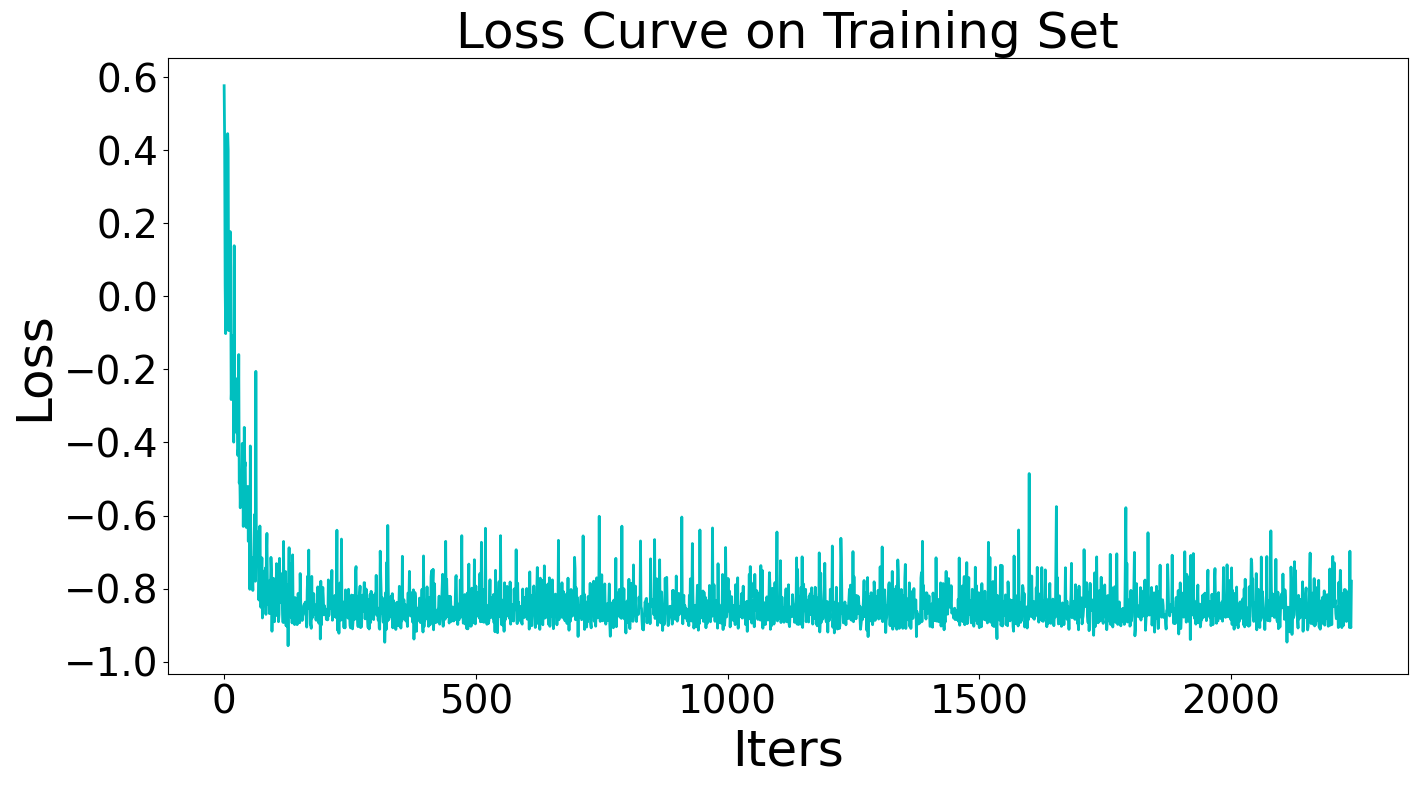

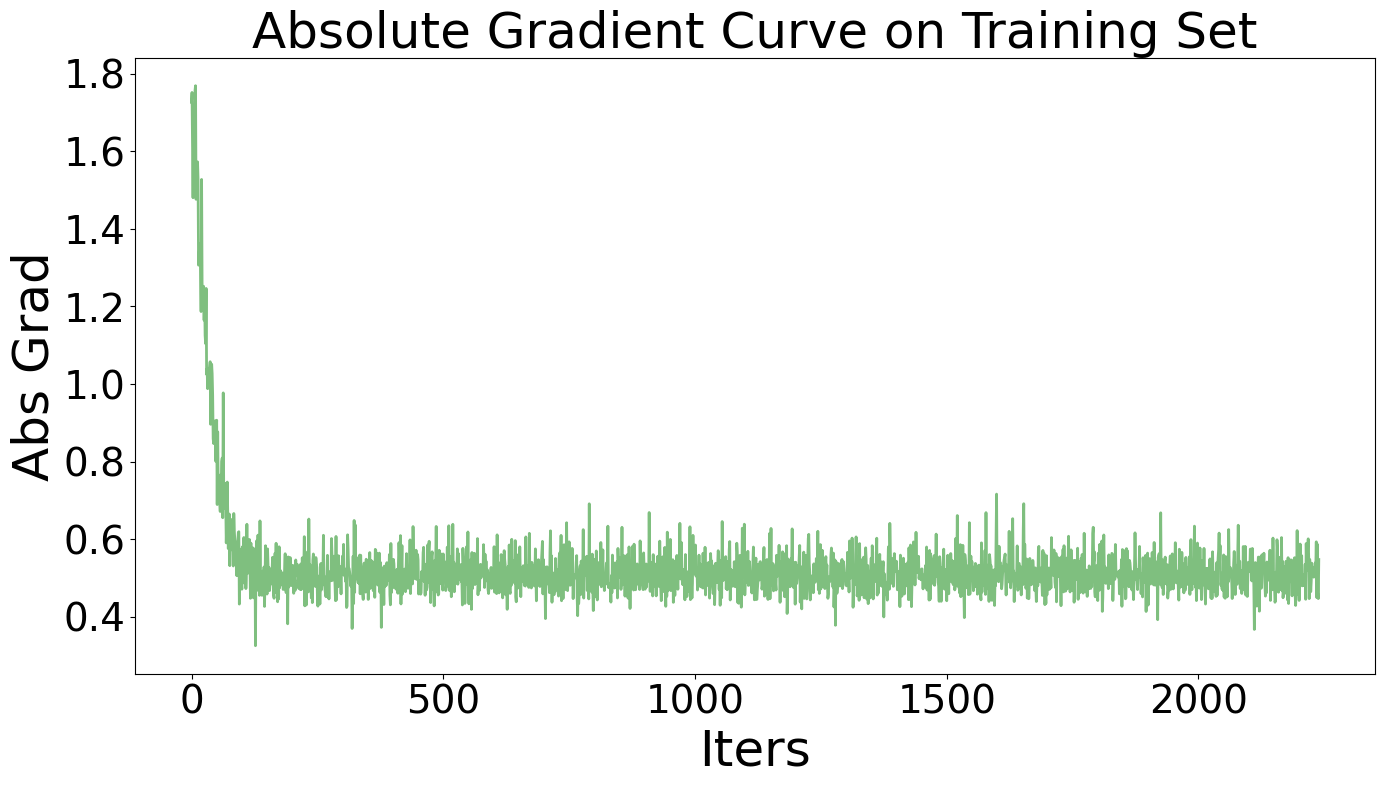

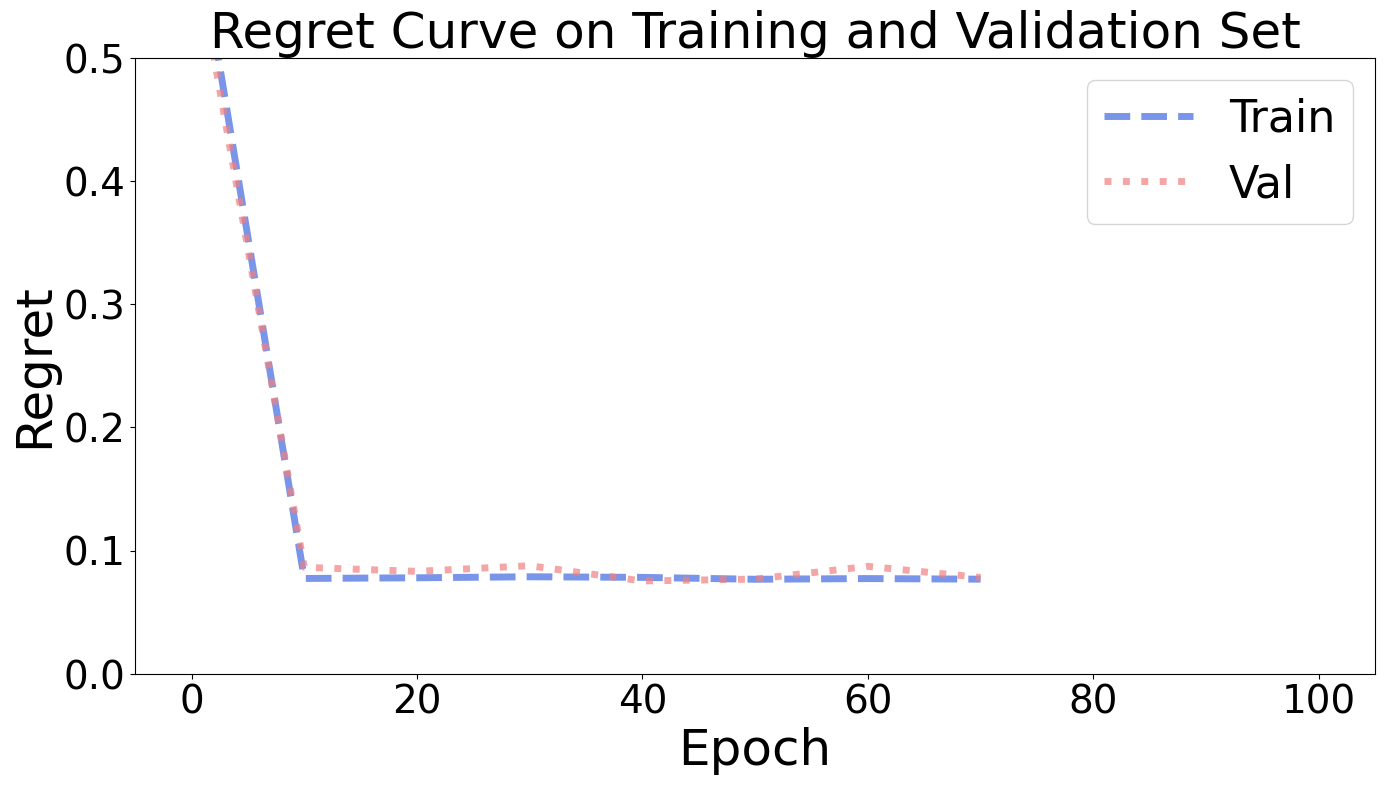

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  55.9797%, Val Regret:  55.0297%


Epoch    9, Loss:  -0.9470:  10%|█████▎                                               | 10/100 [00:33<04:31,  3.02s/it]

Epoch  10, Train Regret:   7.7770%, Val Regret:   8.2572%


Epoch   19, Loss:  -0.8169:  20%|██████████▌                                          | 20/100 [01:03<03:54,  2.93s/it]

Epoch  20, Train Regret:   7.8755%, Val Regret:   8.3225%


Epoch   29, Loss:  -0.8519:  30%|███████████████▉                                     | 30/100 [01:34<03:25,  2.93s/it]

Epoch  30, Train Regret:   7.8903%, Val Regret:   8.9367%


Epoch   39, Loss:  -0.9320:  40%|█████████████████████▏                               | 40/100 [02:04<02:53,  2.89s/it]

Epoch  40, Train Regret:   7.8362%, Val Regret:   7.4325%


Epoch   49, Loss:  -0.4870:  50%|██████████████████████████▌                          | 50/100 [02:36<02:30,  3.00s/it]

Epoch  50, Train Regret:   7.6590%, Val Regret:   8.5890%


Epoch   59, Loss:  -0.9399:  60%|███████████████████████████████▊                     | 60/100 [03:07<01:56,  2.91s/it]

Epoch  60, Train Regret:   7.7742%, Val Regret:   9.0144%


Epoch   69, Loss:  -0.7802:  70%|█████████████████████████████████████                | 70/100 [03:37<01:33,  3.11s/it]


Epoch  70, Train Regret:   7.6942%, Val Regret:   8.0595%

Early Stop!
Training Elapsed Time: 133.69 Sec

Evaluation:
Test Regret: 8.3753%
Test Elapsed Time: 1.52 Sec


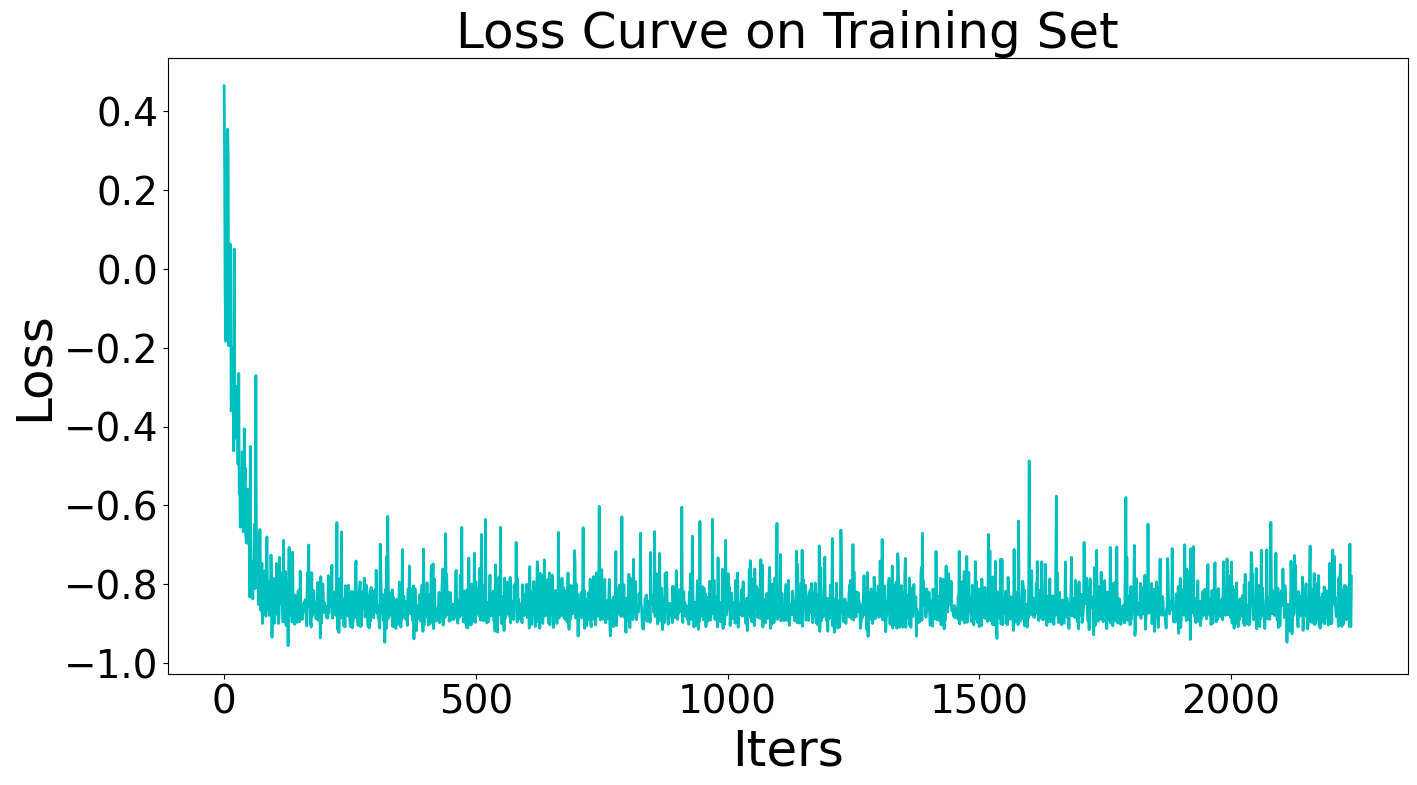

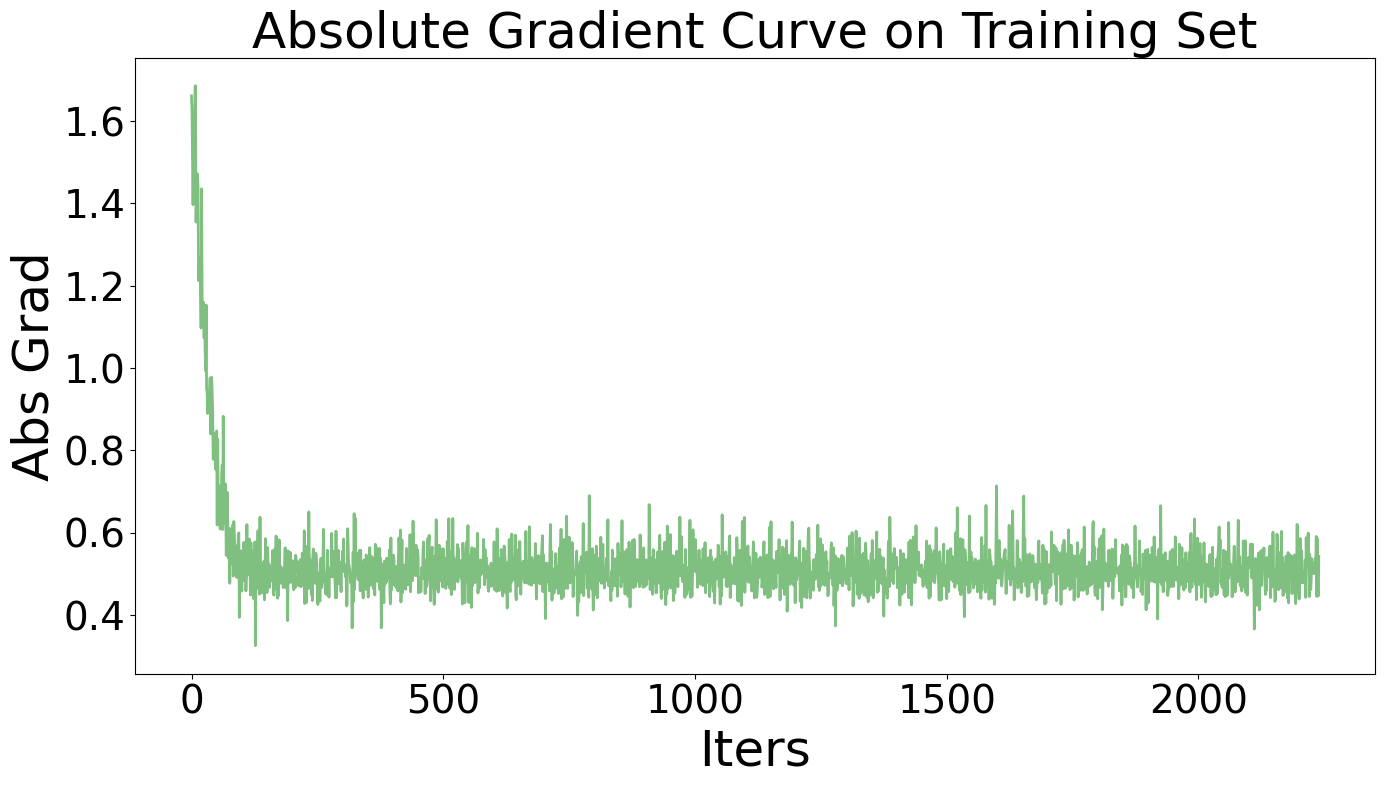

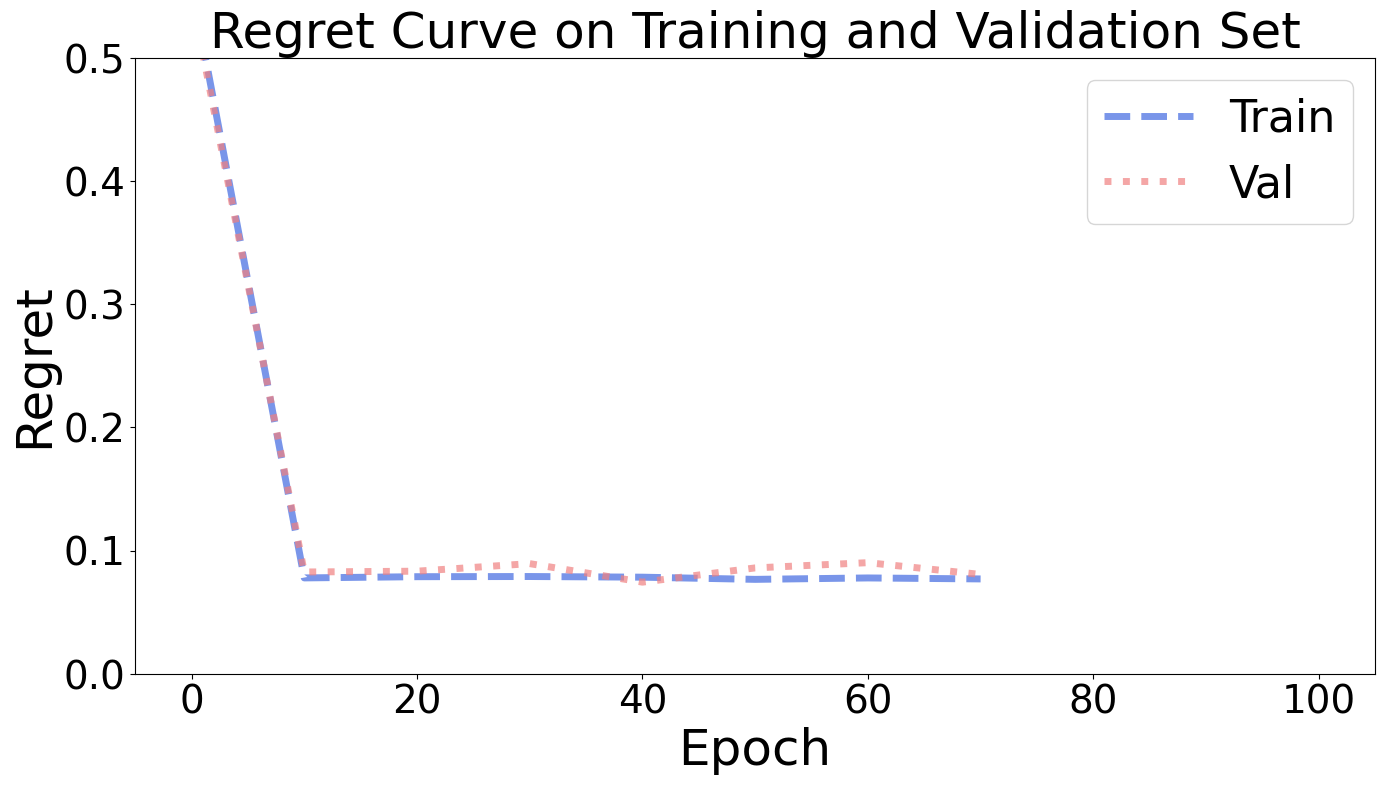

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [34]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  55.9797%, Val Regret:  55.0297%


Epoch    9, Loss:  -0.8615:  10%|█████▎                                               | 10/100 [00:14<01:41,  1.13s/it]

Epoch  10, Train Regret:   7.8074%, Val Regret:   8.2316%


Epoch   19, Loss:  -0.9286:  20%|██████████▌                                          | 20/100 [00:27<01:30,  1.13s/it]

Epoch  20, Train Regret:   7.6931%, Val Regret:   7.9484%


Epoch   29, Loss:  -0.7779:  30%|███████████████▉                                     | 30/100 [00:40<01:19,  1.14s/it]

Epoch  30, Train Regret:   7.5950%, Val Regret:   8.4440%


Epoch   39, Loss:  -0.9065:  40%|█████████████████████▏                               | 40/100 [00:53<01:09,  1.15s/it]

Epoch  40, Train Regret:   7.9245%, Val Regret:   8.5568%


Epoch   49, Loss:  -0.9273:  50%|██████████████████████████▌                          | 50/100 [01:05<01:05,  1.32s/it]


Epoch  50, Train Regret:   7.7919%, Val Regret:   8.1308%

Early Stop!
Training Elapsed Time: 5.59 Sec

Evaluation:
Test Regret: 8.2146%
Test Elapsed Time: 1.52 Sec


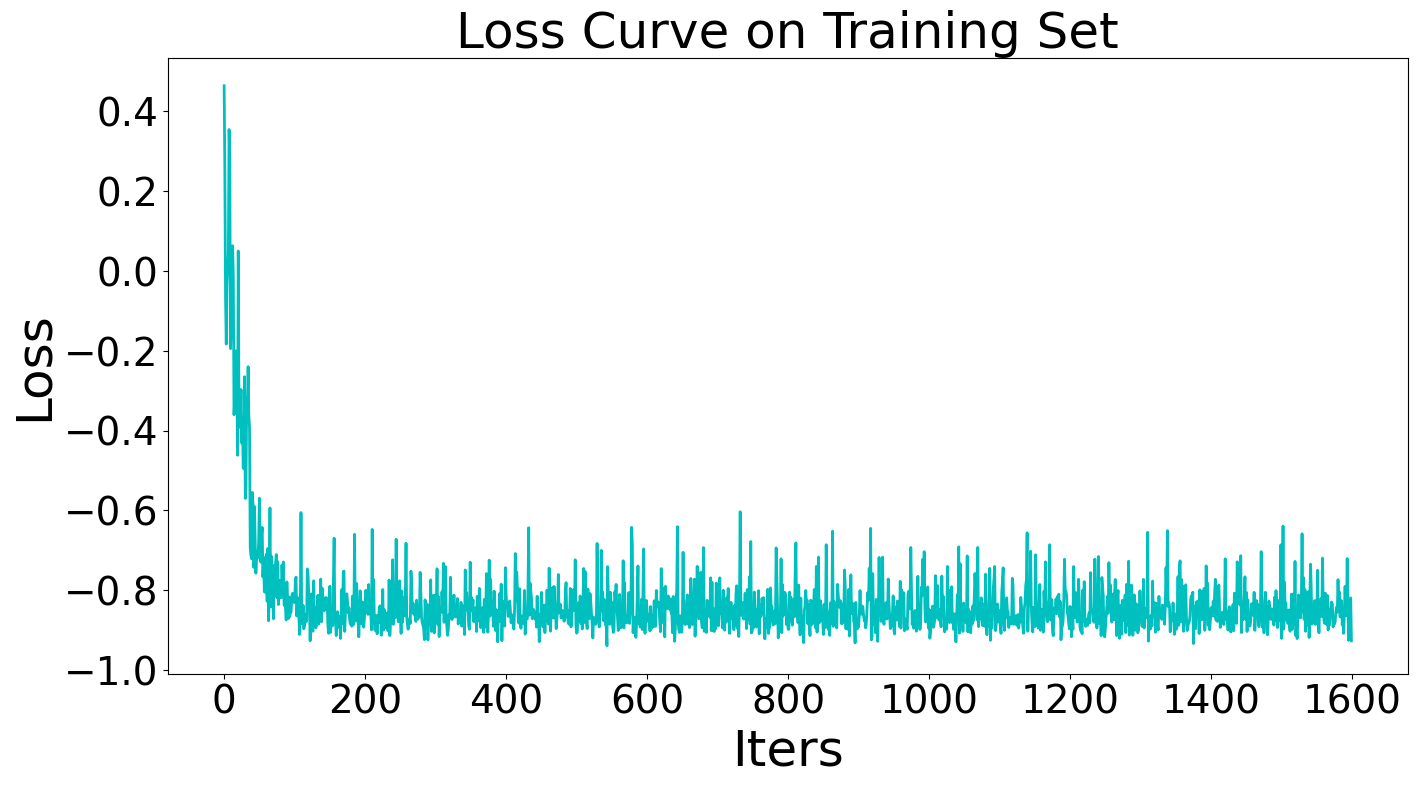

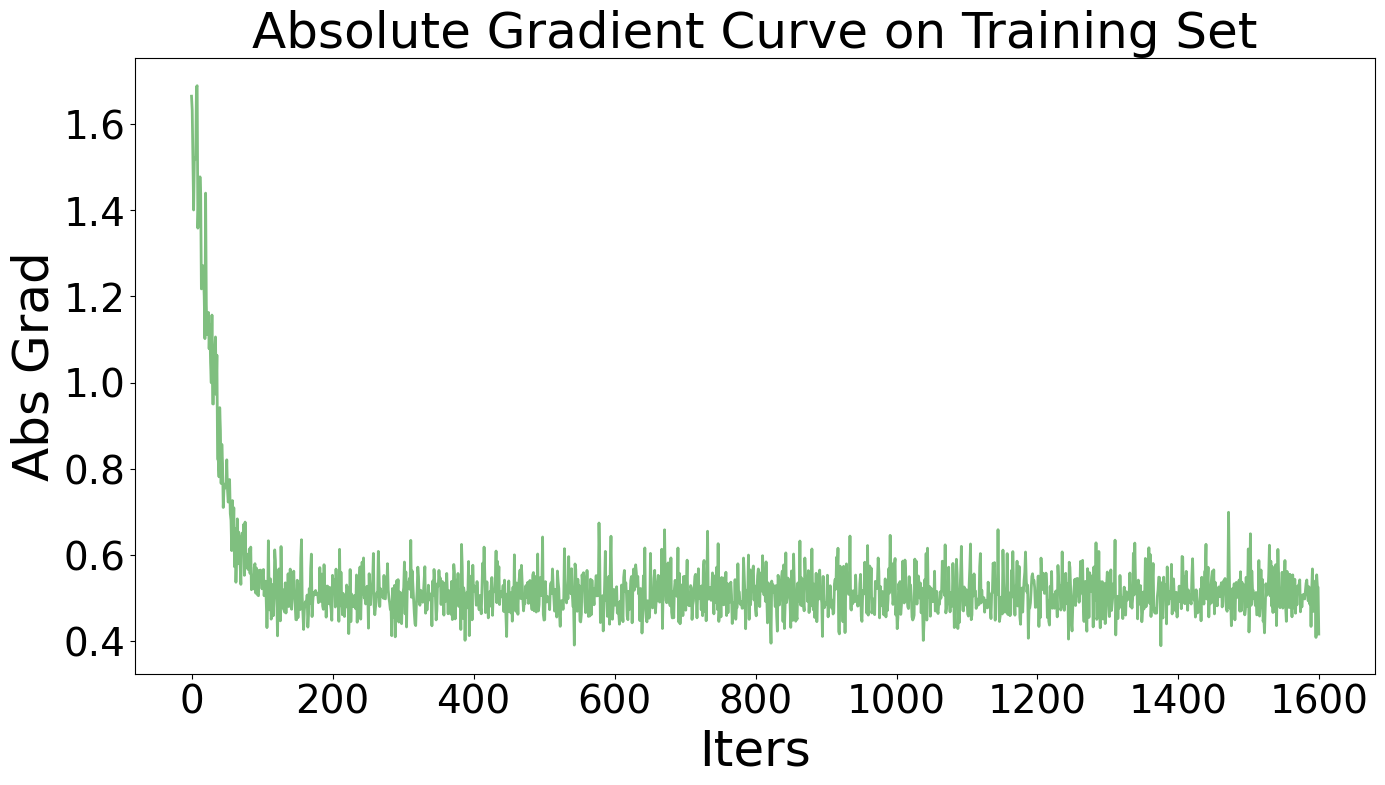

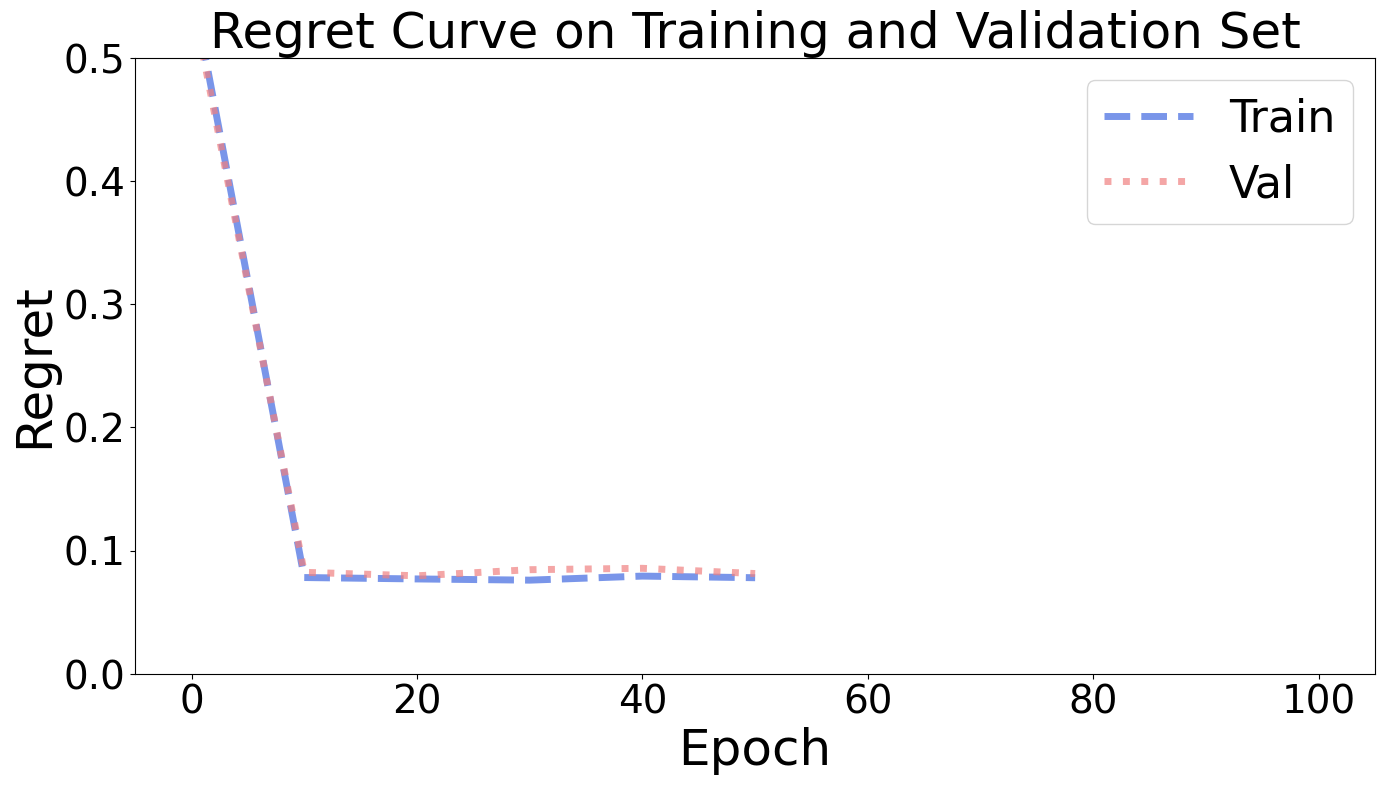

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [38]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:01<?, ?it/s]

Epoch   0, Train Regret:  42.8166%, Val Regret:  39.3185%


Epoch    9, Loss:  -0.8625:  10%|█████▎                                               | 10/100 [00:30<04:12,  2.80s/it]

Epoch  10, Train Regret:   7.9327%, Val Regret:   8.1647%


Epoch   19, Loss:  -0.9290:  20%|██████████▌                                          | 20/100 [01:00<03:44,  2.81s/it]

Epoch  20, Train Regret:   7.7394%, Val Regret:   7.9669%


Epoch   29, Loss:  -0.7768:  30%|███████████████▉                                     | 30/100 [01:30<03:23,  2.91s/it]

Epoch  30, Train Regret:   7.6531%, Val Regret:   8.4691%


Epoch   39, Loss:  -0.9074:  40%|█████████████████████▏                               | 40/100 [02:00<02:48,  2.81s/it]

Epoch  40, Train Regret:   7.8903%, Val Regret:   8.5568%


Epoch   49, Loss:  -0.9272:  50%|██████████████████████████▌                          | 50/100 [02:29<02:29,  3.00s/it]


Epoch  50, Train Regret:   7.8429%, Val Regret:   8.0057%

Early Stop!
Training Elapsed Time: 89.40 Sec

Evaluation:
Test Regret: 8.3982%
Test Elapsed Time: 1.50 Sec


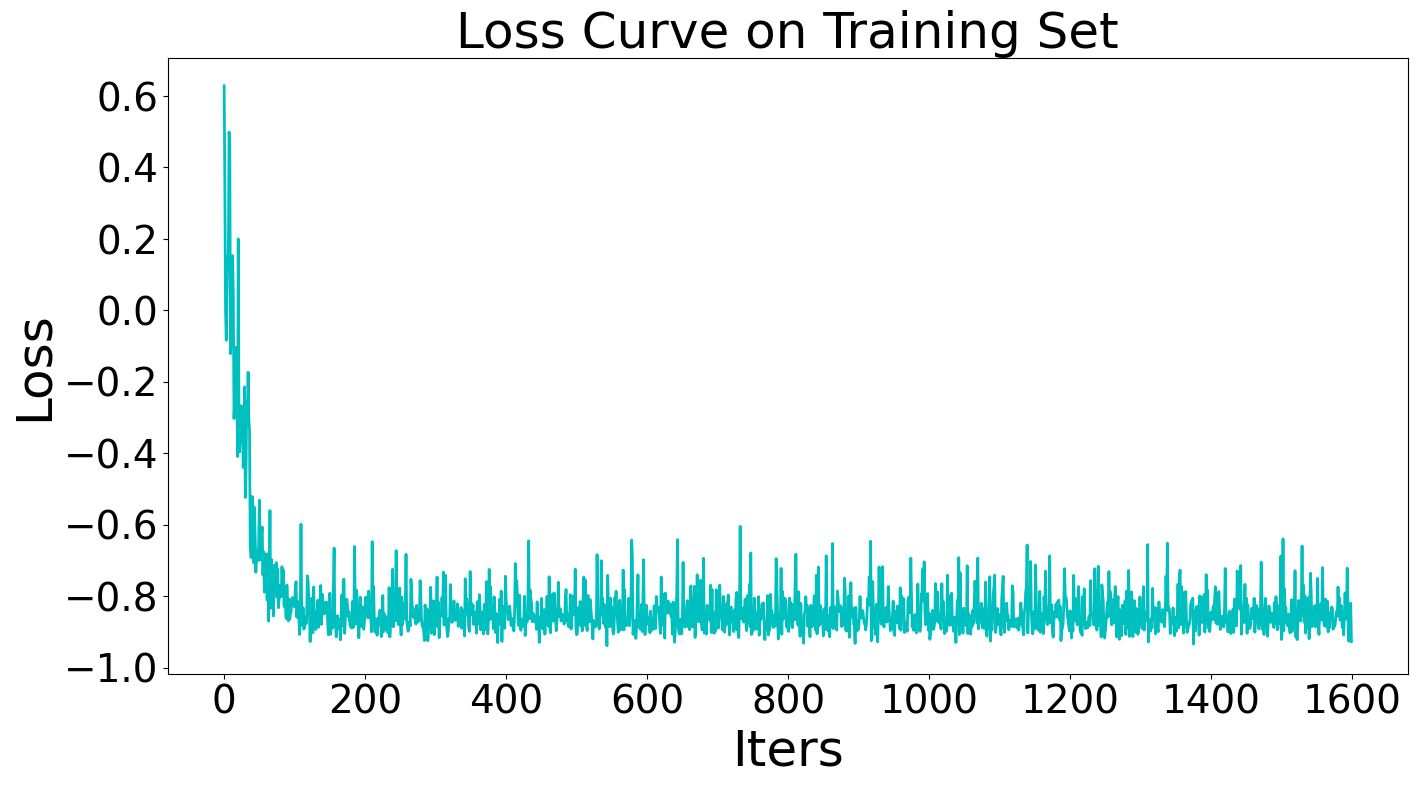

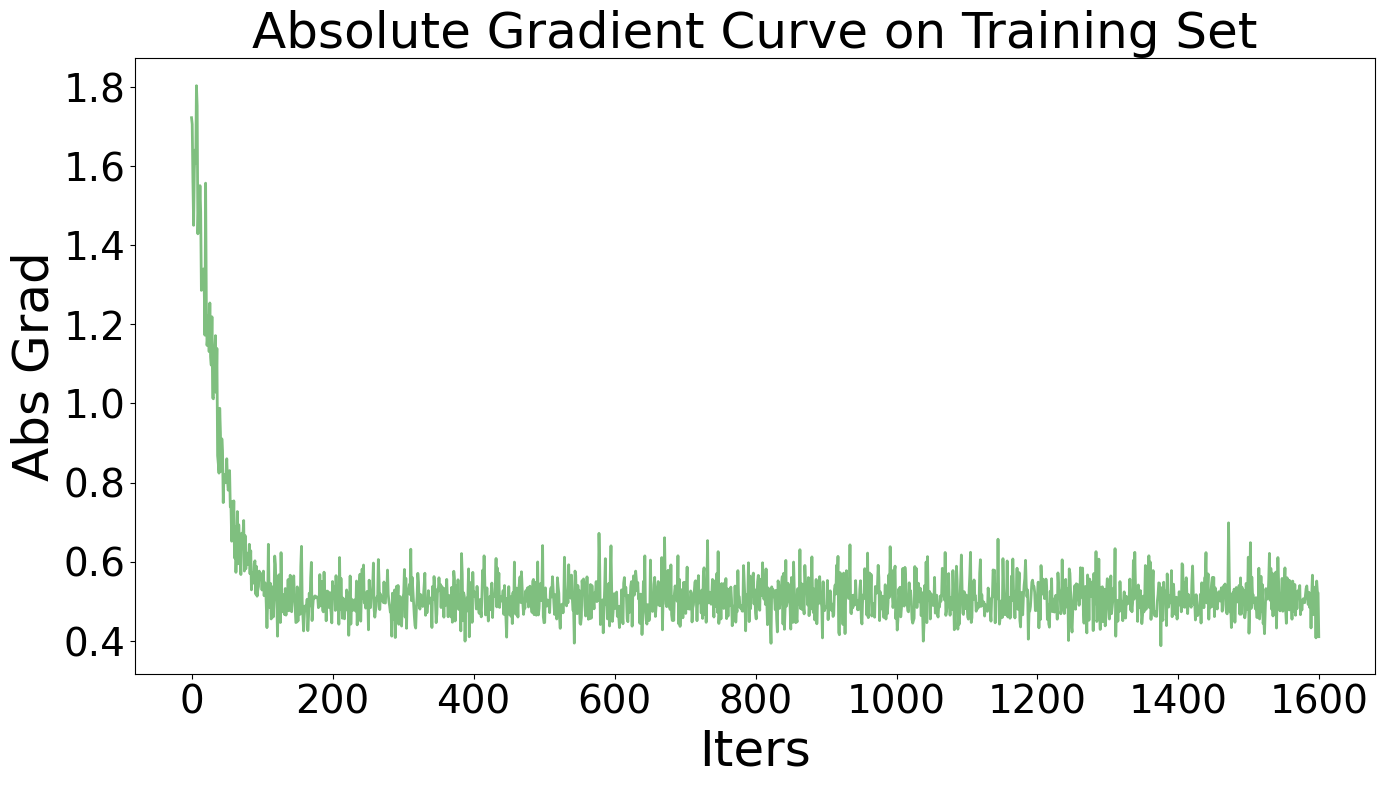

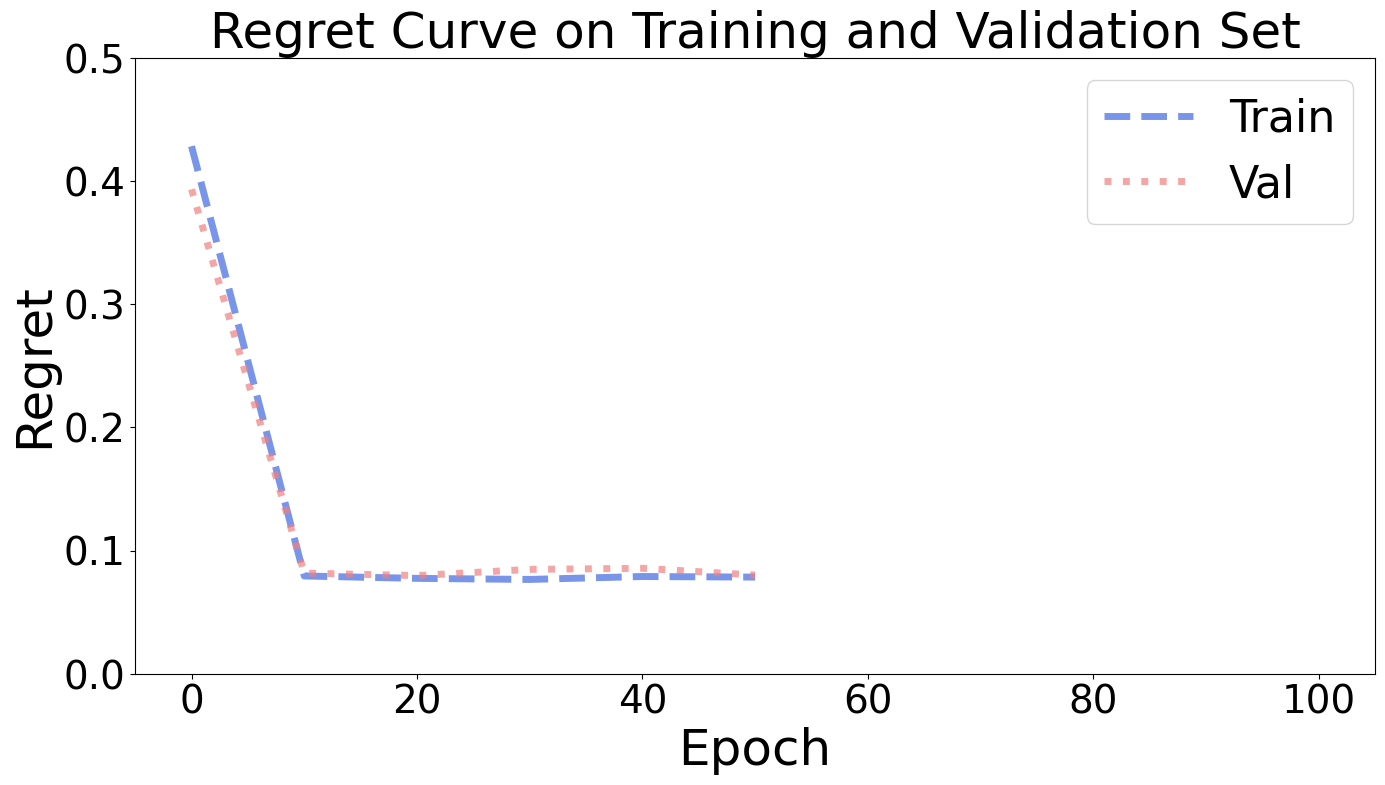

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)